In [2]:
using DataFrames, CSV
using JuMP, Gurobi
using LinearAlgebra, Random, Printf
using Plots

const GRB_ENV = Gurobi.Env()

Academic license - for non-commercial use only - expires 2021-07-08


Gurobi.Env(Ptr{Nothing} @0x00007fbd75fba000, false, 0)

In [3]:
arcs = CSV.read("Pb1_arcs.csv", DataFrame)
od = CSV.read("Pb1_customer_OD.csv", DataFrame)
demand = CSV.read("Pb1_demand.csv", DataFrame)
transport = CSV.read("Pb1_transport.csv", DataFrame);

In [4]:
#--- sets
A = [i for i in 1:nrow(arcs)]
K = [i for i in 1:nrow(od)]
S = [i for i in 1:ncol(demand)];

In [5]:
# arc OD pairs
arc_od = Dict(row[1] => (row[2], row[3]) for row in eachrow(arcs))

# arc capacities
u = Dict(row[1] => row[4] for row in eachrow(arcs))

# arc costs
c = Dict(row[1] => row[5] for row in eachrow(arcs))

# transportation costs
f = Dict((k, a) => transport[a, k] for a in A for k in K)
            
# demand 
d = Dict((k, s) => demand[k, s] for k in K for s in S)

# scenario probability 
prob = 1/2
                        
# customer origins
OD = Dict(k => (od[k, 1], od[k, 2]) for k in K);

In [6]:
#--- vertices
V = unique(vcat([arc_od[a][1] for a in A], [arc_od[a][2] for a in A]))

# node balance
b = Dict((i, k, s) => 0.0 for i in V for k in K for s in S)
for k in K, s in S
    b[(OD[k][1], k, s)] = d[(k, s)]
    b[(OD[k][2], k, s)] = -d[(k, s)]
end;

In [9]:
TIME_LIMIT = 60;
OPTIMALITY_GAP = 0.01;

In [10]:
# define main problem
MP = Model(JuMP.optimizer_with_attributes(() -> Gurobi.Optimizer(GRB_ENV), 
            "OutputFlag" => 0))
set_silent(MP)

@variable(MP, x[A], Bin)
@variable(MP, θ[S] >= 0)
@objective(MP, Min, sum(c[a] * x[a] for a in A) + sum(prob * θ[s] for s in S))


lower_bound_all = []; upper_bound_all = []
MP_time = []; SP_max_time = []; SP_time = []
num_opt = 0; num_feas = 0
while true
    # solve master problem
    push!(MP_time, @elapsed optimize!(MP))
    lower_bound_new = objective_value(MP)
    push!(lower_bound_all, lower_bound_new)
    x_MP = value.(x)

    # solve S subproblems
    obj_SP = zeros(length(S))
    SP_time_all = zeros(length(S))
    for s in S
        SP_dual = Model(JuMP.optimizer_with_attributes(() -> Gurobi.Optimizer(GRB_ENV), 
            "OutputFlag" => 0, "DualReductions" => 0, "TimeLimit" => 60))

        @variable(SP_dual, p[A] >= 0)
        @variable(SP_dual, q[V, K])

        @constraint(SP_dual, [k in K, a in A], q[arc_od[a][1], k] - q[arc_od[a][2], k] - p[a] <= f[(k, a)])

        @objective(SP_dual, Max, sum(b[(i, k, s)] * q[i, k] for i in V, k in K) - 
            sum(u[a] * x_MP[a] * p[a] for a in A))

        SP_time_all[s] = @elapsed optimize!(SP_dual)
        p_val = value.(SP_dual[:p])
        q_val = value.(SP_dual[:q]) 
        if termination_status(SP_dual) == MOI.DUAL_INFEASIBLE 
            # feasibility cut 
            @constraint(MP, 0 >= sum(b[(i, k, s)] * q_val[i, k] for i in V, k in K) - 
            sum(u[a] * x[a] * p_val[a] for a in A))
            obj_SP[s] = 3000
            num_feas += 1
        elseif termination_status(SP_dual) == MOI.OPTIMAL
            # optimality cut
            @constraint(MP, θ[s] >= sum(b[(i, k, s)] * q_val[i, k] for i in V, k in K) - 
            sum(u[a] * x[a] * p_val[a] for a in A))     
            obj_SP[s] = objective_value(SP_dual)
            num_opt += 1
        end
    end
    push!(SP_max_time, maximum(SP_time_all))
    push!(SP_time, sum(SP_time_all))
    upper_bound_new = sum(c[a] * x_MP[a] for a in A) + sum(prob * obj_SP[s] for s in S)
    push!(upper_bound_all, upper_bound_new)
    @printf("Sol: %.2f - Bound: %.2f\n", upper_bound_all[end], lower_bound_all[end])
    if sum(MP_time) + sum(SP_time) >= TIME_LIMIT ||
        (upper_bound_new - lower_bound_new) / lower_bound_new < OPTIMALITY_GAP
        break
    end
end

Sol: 3000.00 - Bound: 0.00
Sol: 3010.05 - Bound: 10.05
Sol: 3010.75 - Bound: 10.75
Sol: 3011.46 - Bound: 11.46
Sol: 3012.90 - Bound: 12.90
Sol: 3020.34 - Bound: 20.34
Sol: 3020.74 - Bound: 20.74
Sol: 3020.81 - Bound: 20.81
Sol: 3020.85 - Bound: 20.85
Sol: 3021.25 - Bound: 21.25
Sol: 3021.31 - Bound: 21.31
Sol: 3021.52 - Bound: 21.52
Sol: 3021.63 - Bound: 21.63
Sol: 3022.02 - Bound: 22.02
Sol: 3023.46 - Bound: 23.46
Sol: 3023.53 - Bound: 23.53
Sol: 3023.62 - Bound: 23.62
Sol: 3023.71 - Bound: 23.71
Sol: 3023.95 - Bound: 23.95
Sol: 3024.19 - Bound: 24.19
Sol: 3024.22 - Bound: 24.22
Sol: 3024.70 - Bound: 24.70
Sol: 3030.40 - Bound: 30.40
Sol: 3030.80 - Bound: 30.80
Sol: 3030.87 - Bound: 30.87
Sol: 3030.89 - Bound: 30.89
Sol: 3030.90 - Bound: 30.90
Sol: 3031.26 - Bound: 31.26
Sol: 3031.31 - Bound: 31.31
Sol: 3031.36 - Bound: 31.36
Sol: 3031.37 - Bound: 31.37
Sol: 3031.58 - Bound: 31.58
Sol: 3032.07 - Bound: 32.07
Sol: 3032.08 - Bound: 32.08
Sol: 3032.19 - Bound: 32.19
Sol: 3032.26 - Bound:

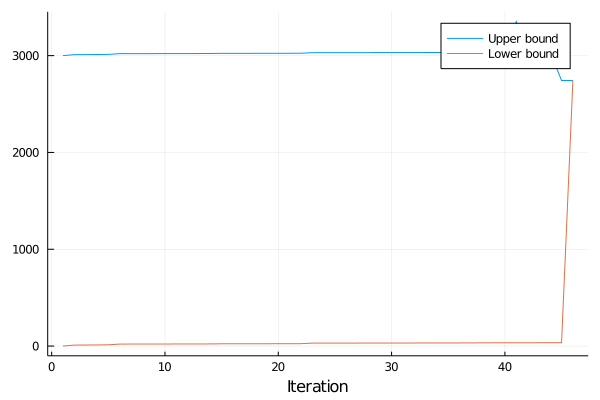

In [11]:
plot([upper_bound_all lower_bound_all], label=["Upper bound" "Lower bound"], xlabel="Iteration")

In [12]:
@show length(upper_bound_all)
@show num_opt 
@show num_feas

length(upper_bound_all) = 46
num_opt = 6
num_feas = 86


86